# Applied economic analysis - Python project

Name: Lukas Buhmann

ANR: 111321

SNR: 2008214

This project work is a numerical simulation of a dynamic general equilibrium model in line with the model setup presented by Antunes, Cavalcanti and Villami in their paper "<a href='#references'> Computing general equilibrium models with occupational choice and ﬁnancial frictions</a>" from 2008 (In the following: Antunes et al 2008a). My analysis is based on the calibration of the paper "<a href='#references'>The effect of financial repression and enforcement on entrepreneurship and economic development</a>" from 2008 (In the following: Antunes et al 2008b) , written by the same authors mentioned above. 

## The model

The model consists of a <a href='#Utility maximization problem'>utility maximization problem</a>, an <a href='#Enterpreneural optimization problem'>entepreneural profit optimization problem</a>, an <a href='#Occupational choice'>occupational choice problem</a> and a <a href='#Market clearing conditions'>market clearing problem</a>: Consider a number $n$ of economic agents with the same utility function that are heterogeuous in the amount of bequest they get from  the previous generation and their enterpreneural talent. In each period in time, given an amount of bequest $b_t$ and a talent variable $x_t$ drawn from a probability distribution for every agent as well as an ex-ante known wage and interest rate level $w_t$ and $r_t$ respectively, agents decide whether to become workers or enterpreneurs. If they decide to become a worker, they get the wage rate $w_t$ as income (we assume perfect competition in the labor and capital market). Else, their income is the result of the enterpreneural optimization problem. This enterpreneural problem is particularly interesting as it includes a capital restriction: If the level of optimal capital employment exceeds the bequest of agent $i$, he can borrow additional funds on the capital market. However, there are capital market imperfections that the model explicitly accounts for. Next, given the capital supply (the sum over all bequests minus the amount of capital used in production) and labor supply (agents that choose to become workers) in period $t$, next period's wage and interest rate are determined by means of a market clearing condition.

This procedure is repeated over multiple periods, resulting (the proofs can be found in the papers listed above) in a steady state wage rate, interest rate and bequest distribution. As other papers using the same model setup do not present further information about the steady state bequest distribution, I am particularly interested in the shape of the steady state distribution and the overall sum of steady state bequests resulting from different calibrations. 


## Financial frictions

The financial friction parameters are $\tau$ and $\phi$, whereas $\tau$ is a markup on per-unit capital costs if funds must be borrowed. $\phi$ is the so-called enforcement parameter that proxys the legal enforcability of borrowers' claims. If this enforcability is very low, $\phi$ is close to zero. If it is high, $\phi$ is close to one. The second financial friction enters the optimization problem by a linear constraint that ensures that the total costs of borrowing must be smaller then a fraction $\phi$ of potential enterpreneural returns.


## The research question

In this project work, I will investigate for possible differences in the steady state bequest distributions across different values for the financial friction parameters. I define a  <a href='#scenario1'>baseline regime</a> analogous to Antunes et al. (2008), a <a href='#scenario2'>good state regime</a> and a <a href='#scenario2'>bad state regime</a>. Additionally, I will provide time paths of wage and interest rate and the share of enterpreneurs across the whole population. My research question is: How does the bequest distribution, the sum over all bequests and the share of enterpreneurs change over the three different financial friction regimes?

## Main assumptions 


1) Utility function satisfies INADA conditions

2) Profit function calibrated such that there is scope for 10 % enterpreneural profit.

3) Perfect competition on capital and labor markets. Wage and interest rate are equal to the marginal product of labor and capital respectively.


## A sneak peak into the results

The main results are:
    
1) The heavier the financial frictions, the lower the overall sum of bequests.

2) There are more enterpreneurs when financial frictions are more relaxed.

3) The interest rate is higher when there are less financial frictions. The wage is hardly affected.

## Final notes

As Antunes et al. (2008b) hardly provide simulation results for their model calibration and as I use a different method to solve the model (I rely on <a href='#solving'> round-by-round solutions</a> of all maximization and root finding problems, looping over an ex-ante defined number of time periods until the steady state is reached), I cannot compare my calculations with benchmark simulation results. Additionally, as I solve the presented model in a purely numerical manner, there might be rounding errors in the results.

A further issue I must address is non-convergence in the results. Given the random talent distribution realizations per period, results sometimes convergence, however sometimes they do not. I will provide results for the case the algorihm converges. If the algorithm does not converge, I invite you, dear supervisor of this script, to re-execute the commands.

The following script explains both the theoretical background and the algorithm steps to solve the model.

## Packages to import

In [98]:
import scipy as sc
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

## Utility maximization problem <a id='Utility maximization problem'></a>

An economic agent lives for one period $t$. During his lifetime, he decides how much to consume and how much of his income to pass to the next generation. An economic agent and all his offsprings are defined as agent $i$. The utility optimization problem for agent i for every period $t$ is $$ max_{b_{t+1}^i, c_{t}^i } u(b,c) = (b_{t+1}^i)^{\gamma} (c_{t}^i)^{1 - \gamma}$$ subject to the budget constraint  $$ b_{t+1}^i + c_{t}^i \leq y_{t}^i $$ 
This yields the optimal solutions: $$(b_{t+1}^i)^* =(1 - \gamma) y_t $$ and $$(c_{t}^i)^* = \gamma y_t $$,

where $ b_{t+1} $ is the bequest for i's offspring, $c_t$ is the agent's consumption in period $t$ and $y_t$ is the income of the agent in $t$. The code below defines the optimial solution for the bequest, as I later need this function in my program. The parameter $a$ replaces the theoretical parameter $1- \gamma$

In [99]:
def optimal_bequest(inc):
    y = a * inc
    return y 

## Enterpreneural optimization problem <a id='Enterpreneural optimization problem'></a>

If an agent decides to become an enterpreneur, his income is determined by the enterpreneural profit function. An enterpreneur's optimization problem has two arguments to maximize for. This problem in terms of labor supply is:

$$ max_n \Pi_{t}^i (k_{t}^i, x_{t}^i, w_t) = x_{t}^i (k_{t}^i)^\alpha (n_{t}^i)^\beta - wn_{t}^i $$
This yields the optimal labor input: $$ (n_{t}^i)^* = \left(\frac{\beta x_{t}^i (k_{t}^i)^\alpha}{w_t} \right)^{\frac{1}{1 - \beta}}  $$

Plugging this result into the profit function yields:

$$ \Pi_{t}^i (k_{t}^i, x_{t}^i, w_t) = (1- \beta) (x_{t}^i (k_{t}^i)^\alpha )^{\frac{1}{1 - \beta}} \left(\frac{\beta}{w_t} \right)^{\frac{\beta}{1 - \beta}}  $$

The code below defines the function above in Python.

In [100]:
def Profit(talent, capital, wage):
    p = (1- beta)*(talent * capital**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) 
    return p

An enterpreuner can use his bequest to self-finance his firm. Define $a_{t}^i$ as the amount of agent i in period t invested by self-finance, i.e. by the bequest and $l_{t}^i$ as the amount of external finance. We define $ k_{t}^i = a_{t}^i + l_{t}^i $.
If an enterpreneur is unconstrained, i.e. he does not externally borrow as $(a_{t}^i)^* \leq b_{t}^i $, his optimization problem is:
$$ max_{a_{t}^i} \Pi_{t}^i (k_{t}^i, x_{t}^i, w_t) = (1- \beta) (x_{t}^i (k_{t}^i)^\alpha )^{\frac{1}{1 - \beta}} \left(\frac{\beta}{w_t} \right)^{\frac{\beta}{1 - \beta}} -(1+r_t)a_{t}^i $$ 

In this case, the optimum level of capital and the level of capital agent $i$ invests in his firm is:

$$ (a_{t}^i)^* =\left(x_{t}^i \left(\frac{\beta}{w_t} \right)^\beta \left(\frac{\alpha}{1+r_t} \right)^{1-\beta} \right)^{\frac{1}{1-\alpha-\beta}} $$ 

However, if $(a_{t}^i)^* > b_{t}^i $, an agent cannot self-finance his firm and the enterpreneurs optimization problem becomes:

$$ max_{a_{t}^i,l_{t}^i} \Pi_{t}^i (k_{t}^i, x_{t}^i, w_t) = (1- \beta) (x_{t}^i (k_{t}^i)^\alpha )^{\frac{1}{1 - \beta}} \left(\frac{\beta}{w_t} \right)^{\frac{\beta}{1 - \beta}} -(1+r_t)a_{t}^i - (1+r_t+ \tau)l_{t}^i $$

subject to the previously introduced enforcement constraint:

$$ (1+r+\tau)l_i \leq \phi \Pi_i (a_i, l_i, x_i, w) $$

The code below implements the unrestricted optimal level of self-financed capital and the optimum level of labor into Python:

In [101]:
def a_opt(talent, wage, interest_rate):
    p = (talent*(beta/wage)**beta * (alpha/(1 + interest_rate))**(1-beta))**(1/(1-alpha-beta))
    return p

def n_opt(talent, wage, cap_opt):
    p = ((beta*talent*cap_opt**alpha)/wage)**(1/(1-beta))
    return p 

In the window below, I first program the unconstrained capital profit function. Second, I use the scipy. optimize package and the fminbound function to maximize the negative profit function with respect to capital. The function optimal_capital_unconstrained calculates the inner solution for the optimum level of capital. The function optimal_profit_unconstrained computes the profit when plugging in the optimal capital level in the profit function.

In [102]:
def profit_unconstrained(talent, capital, wage, interest_rate):
    p = (1- beta)*((talent *  capital**alpha)**(1/(1-beta))) * ((beta/wage)**(beta/(1-beta))) - (1+ interest_rate)*capital
    return p

def optimal_capital_unconstrained(talent,  wage, interest_rate):
    q1 =  sc.optimize.fminbound(lambda capital: -profit_unconstrained(talent, capital, wage, interest_rate),0,1000)
    return q1

def optimal_profit_unconstrained(talent,  wage, interest_rate):
    p = (1- beta)*(talent * optimal_capital_unconstrained(talent, wage, interest_rate)**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+ interest_rate)*optimal_capital_unconstrained(talent, wage, interest_rate)
    return p

In the window below, I program the much more complicated constrained optimization problem. First, in the Profit_constrained function, I define the profit function of the constrained optimization problem. The function optimal_capital_constrained uses the minimize function of scipy to calculate optimal level of self-finance and the optimal level of borrowing. The function minimize needs a vector input, such that I implement $a$ and $l$ in the Profit_constrained function as a vector called "cap". Additionally, I program the previously introduced constraints as "cons1" and "cons2", bundling them in a dictionary called "cons". The output of the function is a vector consisting of the optimal level of self-finance and borrowing. The function "optimal_profit_unconstrained" computes the profit of the constrained profit function when plugging in the optimum capital vector in the profit function.

In [103]:
def Profit_constrained(cap, talent, wage, interest_rate):
    p = (1- beta) * (talent * (cap[0]+cap[1])**alpha)**(1/(1-beta)) * (beta/wage)**(beta/(1-beta)) - (1+interest_rate)*cap[0] - (1+interest_rate+tau)*cap[1]
    return p


def optimal_capital_constrained(bequest, talent, wage, interest_rate):
    
    def cons1(cap, bequest):
            p = bequest - cap[0] -  0*cap[1]
            return p 

    def cons2(cap, talent, wage, interest_rate):
            p = phi*Profit_constrained(cap, talent, wage, interest_rate) - (1+interest_rate+tau)*cap[1]
            return p
    
    cons = ({'type': 'ineq', 'fun': lambda cap: cons1(cap,bequest)}, 
            {'type': 'ineq', 'fun': lambda cap: np.array([cons2(cap, talent, wage, interest_rate)])})
 
    bnds = ((0, 100), (0, 100))
 
    res =  sc.optimize.minimize(lambda cap: -Profit_constrained(cap,talent,wage,interest_rate),
                                x0 = [2,2],
                                constraints=cons, 
                                method='SLSQP',bounds = bnds)
    return res.x

def optimal_profit_constrained(bequest,talent, wage, interest_rate): 
    return Profit_constrained(optimal_capital_constrained(bequest, talent, wage, interest_rate),talent,wage,interest_rate)



## Occupational choice <a id='Occupational choice'></a>

The next window contains the core body of my algorithm. It computes the occupational choice of an economic agent, i.e. it determines whether an economic agent becomes a worker or an enterpreneur. The basic idea is, given $x_{t}^i$, $b_{t}^i$ and the initial wage and interest rate $w_t$ and $r_t$, an agent simply compares his potential enterpreneural return and the wage rate.
If $$\Pi_{t}^i (b_{t}^i,  x_{t}^i, w_t, r_t) \geq w_t$$,

the agent chooses to become an enterpreneur. Else if  $$\Pi_{t}^i (b_{t}^i,  x_{t}^i, w_t, r_t) < w_t$$, the agent chooses to become a worker. First, I compute the potential enterpreneural profit of every agent and safe it in a np.array called income. Second, for every agent I compare whether his/ her enterpreneural profit is smaller than the wage rate. If yes, the agent chooses to become a worker. If no, the agent "stays" an enterpreneur. Additionally, I compute dichotomous variables indicating whether an agent is an enterpreneur or not, and whether he is a capital constrained or a capital unconstrained enterpreneur. 

In [104]:
def program_loop(bequests,talents,wage,interest_rate):
    income = np.array([])
    ent_unc_indicator = np.array([])
    ent_con_indicator = np.array([])
    wor_indicator = np.array([])
    ent_indicator = np.ones(len(bequests))
    for i in range(len(talents)):
        if bequests[i] >= a_opt(talents[i] , wage, interest_rate):
            income = np.append(income, optimal_profit_unconstrained(talents[i],wage,interest_rate))
            ent_unc_indicator = np.append(ent_unc_indicator,1)
            wor_indicator = np.append(wor_indicator,0)
            ent_con_indicator = np.append(ent_con_indicator,0)
            ent_indicator[i] = 1
        else:
            income = np.append(income, optimal_profit_constrained(bequests[i],talents[i],wage,interest_rate))
            ent_unc_indicator = np.append(ent_unc_indicator,0)
            wor_indicator = np.append(wor_indicator,0)
            ent_con_indicator = np.append(ent_con_indicator,1)
            ent_indicator[i] = 1
    for i in range(len(talents)):
        if income[i] < wage:
            income[i] = wage
            ent_con_indicator[i] = 0
            ent_unc_indicator[i] = 0
            wor_indicator[i] = 1
            ent_indicator[i] = 0
    return income, ent_unc_indicator, wor_indicator, ent_con_indicator, ent_indicator

## Market clearing conditions <a id='Market clearing conditions'></a>

The last part of the program determines the equilibria in the capital and labor market. Let $\iota_{wor}$ and $\iota_{ent}$ be dichotomous variables indicating whether an agent is a worker or an enterpreneur respectively. Additionally, let $k(x_{t}^i, n_{t}^i, w_t, r_t)$ and $n(x_{t}^i, n_{t}^i, w_t, r_t)$ be the optimum level of capital and optimum level of labor employed by agent i in production.
The next periods's wage and interest rate tupel $(w_t,r_t)$ is determined by solving the non-linear equation system with respect to interest rate and wage:
$$ \sum_{i=1}^n  \iota_{wor} - \iota_{ent} \times n(x_{t}^i, n_{t}^i, w_t, r_t) = 0 \\
   \sum_{i=1}^n  b_{t}^i - \iota_{ent} \times k(x_{t}^i, n_{t}^i, w_t, r_t) = 0$$
   
This I do by first translating both equations above into Python (by the functions "labor_marketclearing" and "capital_marketclearing"), building a vectorized function "func" out of both and then using the scipy function "root".


All other functions are of technical nature. To avoid excessive fluctuations, Antunes et al (2008a, 2008b) smooth the time paths of interest rate and wage. Let us first define 

$$X_t = \frac{ \sum_{i=1}^n  \iota_{wor} - \iota_{ent}  n(x_{t}^i, n_{t}^i, w_t, r_t)}{\sum_{i=1}^n  \iota_{wor}}$$
as the average excess labor supply in period $t$ and 
$$ Y_t = \frac{ \sum_{i=1}^n  b_{t}^i - \iota_{ent} k(x_{t}^i, n_{t}^i, w_t, r_t)}{\sum_{i=1}^n  b_{t}^i} $$
as the excess capital supply as a fraction of total wealth.
 
Assume the wage and interest rate transition function to be:


$$  \begin{pmatrix} w_{t+1} \\ r_{t+1} \end{pmatrix} = \begin{pmatrix} w_{t} \\ r_{t} \end{pmatrix} + \sigma \times  \begin{pmatrix} a_1 \\ a_2 \end{pmatrix} \times \begin{pmatrix} X_t \\ Y_t \end{pmatrix}  $$

The last vector consists of the average labor excess and capital excess as a fraction of total wealth across agents in time $t$. $\sigma$ is a smoothing parameter and  is in a range between zero and one. The parameter $a_1$ and $a_2$ must be chosen such that they reflect the dynamics of the non-smoothed time path of wage and interest rate. Thus, given $\sigma = 1$, i calculate both parameters given the following rule:

$ \hspace{10cm} \begin{bmatrix} a_1 \\ a_2 \end{bmatrix} = {\large \begin{bmatrix} \frac{ w_{t+1}(\sigma = 1) - w_{t}}{{X_t}} \\ \frac{r_{t+1}(\sigma = 1) - r_{t}}{Y_t} \end{bmatrix}}$,

whereas $  w_{t+1}(\sigma = 1) $ and $ r_{t+1}(\sigma = 1)$ can be found by using the "root" function as explained above. Given that  $ 0 < \sigma < 1$, this procedure leads to adequat smoothing out of erratic wage and interest rate dynamics. 

The function "av_func" creates $X_t$ and $Y_t$, the function "clear_all" calculates $  w_{t+1}(\sigma = 1) $ and $ r_{t+1}(\sigma = 1)$. Finally, the function "converge" calculates the parameter $ a_1$ and  $ a_2$.



In [105]:
def labor_marketclearing(bequests,talents, wage, interest_rate,ent_indicator_1, wor_indicator_1):
    labor_clearing = []
    for i in range(len(talents)):
        if ent_indicator_1[i] == 1:
                p = -n_opt(talents[i], wage, sum(optimal_capital_constrained(bequests[i],talents[i],wage, interest_rate)))
                labor_clearing.append(p)
        elif wor_indicator_1[i] ==1:
                p = 1
                labor_clearing.append(p)
    return sum(labor_clearing)

def cap_marketclearing(bequests, talents, wage, interest_rate,ent_indicator_1, wor_indicator_1):
    capital_clearing = []
    for i in range(len(talents)):
        if ent_indicator_1[i] == 1:
                p = bequests[i] - sum(optimal_capital_constrained(bequests[i],talents[i],wage, interest_rate))
                capital_clearing.append(p)
        elif wor_indicator_1[i] ==1:
                p = bequests[i]
                capital_clearing.append(p)
    return sum(capital_clearing)


def func(prices,bequests, talents, ent_indicator_1, wor_indicator_1):
    
    wage = prices[0]
    interest_rate = prices[1]
    
    F = np.empty(2)
    F[0] = labor_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)
    F[1] = cap_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)
    return F

def clear_all(prices,bequests, talents, ent_indicator_1, wor_indicator_1): 
    
    res = sc.optimize.root(func, args = (bequests,talents, ent_indicator_1, wor_indicator_1) , method = 'lm',tol=0.00002,x0 = (0.04,0.04))
    return res.x

def avfunc(prices,bequests, talents, ent_indicator_1, wor_indicator_1):
    
    wage = prices[0]
    interest_rate = prices[1]
    
    F = np.empty(2)
    F[0] = labor_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)/sum(wor_indicator_1)
    F[1] = cap_marketclearing(bequests, talents, wage, interest_rate, ent_indicator_1, wor_indicator_1)/sum(bequests)
    return F
 

def converge(prices,bequests,talents, new_prices,avlabor,avcapital,ent_indicator_1, wor_indicator_1):
    
    wage = prices[0]
    interest_rate = prices[1]
    w = new_prices[0]
    r = new_prices[1]
    
    p = np.empty(2)
    p[0] = (w - wage)/avlabor
    p[1] = (r - interest_rate)/avcapital
    
    return p

## Income and bequest

Finally, we need to generate the income for agent $i$ and the resulting next period's bequest for every agent and his/ her offspring $i$ in period $t$. For this purpose, we use the income vector generated by "program_loop". Formally, the income $y_{t}^i$ of every agent is defined as: 

$$ y_{t}^i =  max \{ \Pi_{t}^i (b_{t}^i,  x_{t}^i, w_t, r_t),  w_t \}  + (1+ r_t) b_{t}^i$$

Agent $i$'s income is thus first determined by the occupational choice and second by the amount of bequest of agent $i$. If this agent is a worker, he can invest his bequest into other enterpreneural projects, getting a capital return of $(1+r_t) b_{i}^t$. If he/ she is an enterpreneur, he/ she gets the capital return of his/ her bequest invested in the own enterpreneural project, which is also equal to $(1+r_t) b_{i}^t$. This function is implemented by the function "generate_income".

The bequest agents transfer to their offsprings is defined by the optimal bequest function determined by the utility maximization problem. I calculate this bequest, $b_{t+1}^i$ as:

$$ b_{t+1}^i = (1-  \gamma ) y_{t}^i $$

This is done by the function "generate_bequest".

In [106]:
def generate_income(income,bequests,interest_rate):
        new_income = np.array([])
        for i in xrange(number_agents):
            new_income = np.append(new_income, income[i] + (1+interest_rate)*bequests[i])       
        return new_income   
    
def generate_bequest(income):
        new_bequest = np.array([])
        for i in xrange(number_agents):
            new_bequest = np.append(new_bequest, optimal_bequest(income[i]))   
        return new_bequest

# Solving the model <a id='solving'></a>

I now construct and solve the model by means of the functions I created above. The function "simulation" which can be found below establishes a dynamic loop over the different steps programmed in the previous steps. For a better understanding, I annotated the code. The loop ends if an ex-ante defined condition is found to be true. That is, two subsequent wage rates and two subsequent interest rates must not deviate from each other by more than 0.01. This I define to be the steady state of the model.

The talents are drawn from a cumulative exponential distribution of the form $F(x) = x^{\frac{1}{4.422}}$. As an initial bequest distribution, I choose a uniform distribution with $0.3$ units of initial capital endowment for each agent.

The initial wage $w_0$ and initial interest rate $r_0$ are chosen to be 0.3.



In [113]:
def simulation(number_agents,w0,r0,b0=0.3, tol = 0.01, max_t_loops=29):
    
    #initialization of variables
    
    

    w = np.zeros(max_t_loops+1)
    r = np.zeros(max_t_loops+1)
    wstar = np.zeros(max_t_loops)
    rstar = np.zeros(max_t_loops)

    income_1  = np.zeros(shape = (max_t_loops,number_agents))
    ent_unc_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    wor_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    ent_con_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    ent_indicator_1 = np.zeros(shape = (max_t_loops,number_agents))
    
    ndincome =  np.zeros(shape = (max_t_loops,number_agents))
    ndtalents = np.zeros(shape = (max_t_loops,number_agents))
    ndbequests = np.zeros(shape = (max_t_loops+1,number_agents))
    entind = np.zeros(max_t_loops) 

    
    #Loop the program over time

    t=1
    while True: 
        print t
        
        #Determine talent dist. per period
        ndtalents[t,:]=np.random.power(1/4.422,number_agents)
        #determine initial bequest dist.
        ndbequests[1,:].fill(b0)
        #determine initial wage and ir
        w[1] = w0
        r[1] = r0

        #occupational choice
        [income_1[t,:], ent_unc_indicator_1[t,:], wor_indicator_1[t,:],
        ent_con_indicator_1[t,:], ent_indicator_1[t,:]] = program_loop(ndbequests[t,:], ndtalents[t,:],w[t],r[t])
        
        #find root of the labor and capital market clearing function
        wstar[t], rstar[t] = clear_all([w[t], r[t]],ndbequests[t,:], ndtalents[t,:], ent_indicator_1[t,:], wor_indicator_1[t,:])
        
        #smooth the time paths of wage and interest rate
        excess = np.ndarray(shape = (1, 2))
        excess = avfunc([w[t],r[t]], ndbequests[t,:],ndtalents[t,:], ent_indicator_1[t,:], wor_indicator_1[t,:])

        conv = np.ndarray(shape = (1, 2))
        conv = converge([w[t],r[t]],ndbequests[t,:], ndtalents[t,:], [wstar[t], rstar[t]],excess[0],excess[1], ent_indicator_1[t,:], wor_indicator_1[t,:])

        w[t+1] = w[t] + sigma* conv[0]*excess[0]

        r[t+1] = r[t] + sigma* conv[1]*excess[1]
        
        #generate agents' income
        ndincome[t,:] = generate_income(income_1[t,:],ndbequests[t,:],r[t])
        
        #generate next period's bequest distribution
        ndbequests[t+1,:] = generate_bequest(ndincome[t,:])
        
        #determine share of enterpreneurs
        entind[t]=sum(ent_indicator_1[t,:])/number_agents
        
        #stop loop condition
        if w[t]- tol < w[t+1] < w[t] +tol and r[t]- tol < r[t+1] < r[t] +tol:
            print 'break'
            print t
            break
            
        if t == max_t_loops - 1:
            break

        t+=1

    #determine final loop number
    nn=np.sum(w>0)
    nn=nn+1
    
    #adjust the variables to final loop number
    w = w[:nn]
    r = r[:nn]
    

    ndincome = ndincome[:nn,:]
    ndtalents = ndtalents[:nn,:]
    ndbequests = ndbequests[:nn,:]

    return w, r,ndincome,ndbequests,entind,nn, wstar, rstar, income_1, ent_unc_indicator_1, wor_indicator_1, ent_con_indicator_1, ent_indicator_1

## Baseline scenario - Calibration <a id='scenario1'></a>

The next window shows the parameter calibration I use for the baseline scenario analogous to the calibration of Antunes et al. (2008b):

$$ a = (1-  \gamma ) = 0.06  \\ b = \gamma = 0.94 \\  beta = \beta = 0.55  \\ alpha = \alpha = 0.35  \\ phi = \phi = 0.26\\ 
 tau = \tau = 0.005 $$ 

 

 

  


Additionally, I choose $\sigma = 0.2 $. All parameter values except for $\tau$ and $\phi$ stay the same across all scenarios.



In [152]:
phi = 0.26
tau = 0.005
a = 0.06

beta = 0.55
alpha = 0.35

sigma = 0.2

In [153]:
number_agents = 500
w0=0.3
r0=0.3
w, r,ndincome,ndbequests,entind,nn, wstar, rstar, income_1, ent_unc_indicator_1, wor_indicator_1, ent_con_indicator_1, ent_indicator_1 = simulation(number_agents,w0,r0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
break
17


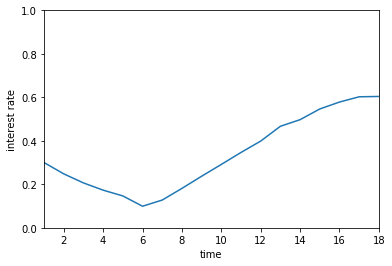

the steady state interest rate is: 0.604048958045
the steady wage is: 0.0720647169594
the share of enterpreneurs is :  0.07


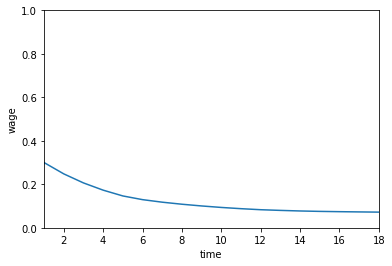

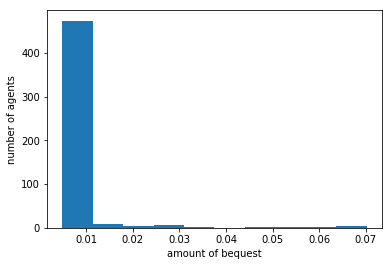

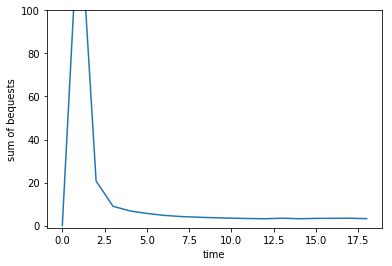

the steady state sum over all bequests is:  3.24809362013


In [159]:
plt.plot(r)
axes = plt.gca()
plt.ylabel('interest rate')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn-1])
plt.show()

print "the steady state interest rate is:", r[nn-1]
print "the steady wage is:", w[nn-1]

print 'the share of enterpreneurs is : ', entind[nn-2]

plt.plot(w)
axes = plt.gca()
plt.ylabel('wage')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn-1])
plt.show()


plt.hist(ndbequests[len(w)-1,:])
plt.ylabel('number of agents')
plt.xlabel('amount of bequest')
axes.set_xlim([1,5])
plt.show()

sumbequests = []
for i in xrange(len(ndbequests)):
    
    p = sum(ndbequests[i,:])
    sumbequests.append(p)
 
plt.plot(sumbequests)
plt.ylabel('sum of bequests')
plt.xlabel('time')
axes = plt.gca()
axes.set_ylim([-1,100])
plt.show()

print 'the steady state sum over all bequests is: ', sumbequests[nn-1]

# Solving the model: Better financial system scenario <a id='scenario2'></a>

In this calibration, the financial frictions are relaxed. The new financial frictions parameters are:
$$ \phi = 2 \times \phi_{baseline}$$

$$\tau = \frac{1}{2} \times \tau_{baseline} $$

In [140]:
phi = 0.52
tau = 0.0025

In [142]:
number_agents = 500
w0=0.3
r0=0.3
w2, r2,ndincome2,ndbequests2,entind2, nn2, wstar2, rstar2, income_2, ent_unc_indicator_2, wor_indicator_2, ent_con_indicator_2, ent_indicator_2 = simulation(number_agents,w0,r0, tol =0.01, max_t_loops=40)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
break
17


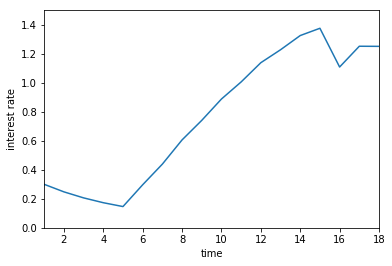

the steady state interest rate is: 1.25167691675
the steady wage is: 0.0710264720363
the share of enterpreneurs is :  0.076


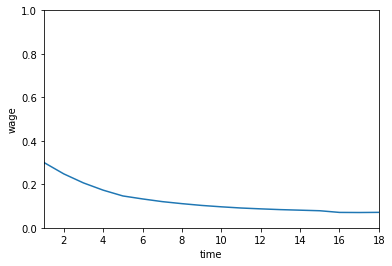

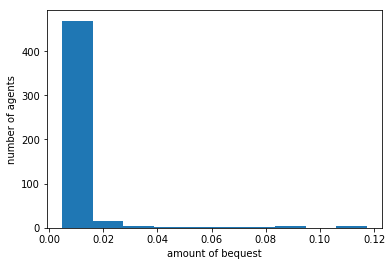

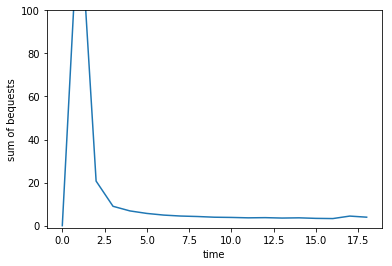

the steady state sum over all bequests is:  3.93018820634


In [160]:
plt.plot(r2)
axes = plt.gca()
plt.ylabel('interest rate')
plt.xlabel('time')
axes.set_ylim([0,1.5])
axes.set_xlim([1,nn2-1])
plt.show()

print "the steady state interest rate is:", r2[nn2-1]
print "the steady wage is:", w2[nn2-1]

print 'the share of enterpreneurs is : ', entind2[nn2-2]

plt.plot(w2)
axes = plt.gca()
plt.ylabel('wage')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn2-1])
plt.show()


plt.hist(ndbequests2[len(w2)-1,:])
plt.ylabel('number of agents')
plt.xlabel('amount of bequest')
axes.set_xlim([1,5])
plt.show()

sumbequests = []
for i in xrange(len(ndbequests2)):
    
    p = sum(ndbequests2[i,:])
    sumbequests.append(p)
 
plt.plot(sumbequests)
axes = plt.gca()
plt.ylabel('sum of bequests')
plt.xlabel('time')
axes.set_ylim([-1,100])
plt.show()

print 'the steady state sum over all bequests is: ', sumbequests[nn2-1]

# The bad scenario <a id='scenario3'></a>

In this scenario, financial frictions are tightened. The new financial frictions parameters are:
    
In this calibration, the financial frictions are relaxed. The new financial frictions parameters are:
$$ \phi = \frac{1}{2} \times \phi_{baseline}$$

$$\tau = 2 \times \tau_{baseline} $$

In [155]:
phi = 0.13
tau = 0.01

In [156]:
number_agents = 500
w0=0.3
r0=0.3
w3, r3,ndincome3,ndbequests3,entind3, nn3, wstar3, rstar3, income_3, ent_unc_indicator_3, wor_indicator_3, ent_con_indicator_3, ent_indicator_3 = simulation(number_agents,w0,r0, tol =0.01, max_t_loops=40)

1
2
3
4
5
6
7
8
9
10
11
break
11


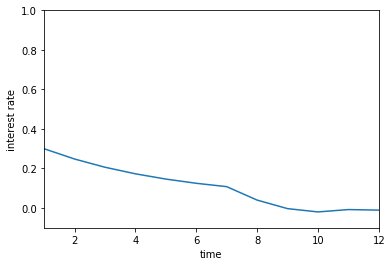

the steady state interest rate is: -0.0106890407186
the steady wage is: 0.0746341099724
the share of enterpreneurs is :  0.066


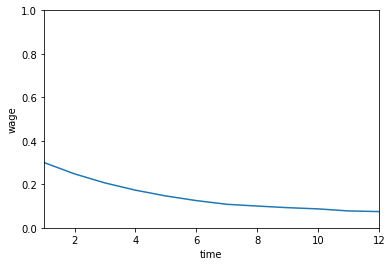

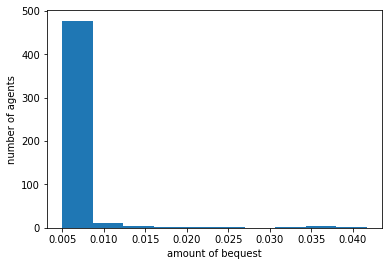

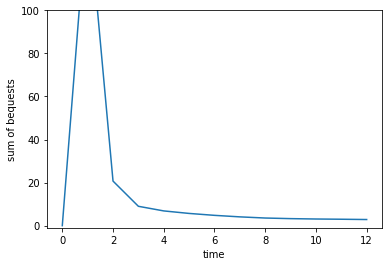

the steady state sum over all bequests is:  2.84252382155


In [161]:
plt.plot(r3)
axes = plt.gca()
plt.ylabel('interest rate')
plt.xlabel('time')
axes.set_ylim([-0.1,1])
axes.set_xlim([1,nn3-1])
plt.show()

print "the steady state interest rate is:", r3[nn3-1]
print "the steady wage is:", w3[nn3-1]

print 'the share of enterpreneurs is : ', entind3[nn3-2]

plt.plot(w3)
axes = plt.gca()
plt.ylabel('wage')
plt.xlabel('time')
axes.set_ylim([0,1])
axes.set_xlim([1,nn3-1])
plt.show()


plt.hist(ndbequests3[len(w3)-1,:])
plt.ylabel('number of agents')
plt.xlabel('amount of bequest')
axes.set_xlim([1,5])
plt.show()

sumbequests = []
for i in xrange(len(ndbequests3)):
    
    p = sum(ndbequests3[i,:])
    sumbequests.append(p)
 
plt.plot(sumbequests)
axes = plt.gca()
plt.ylabel('sum of bequests')
plt.xlabel('time')
axes.set_ylim([-1,100])
plt.show()

print 'the steady state sum over all bequests is: ', sumbequests[nn3-1]

## Results

## References <a id='references'></a>

[1] Antunes, A., Cavalcanti, T., & Villamil, A. (2008). Computing general equilibrium models with occupational choice and financial frictions. Journal of Mathematical Economics, 44(7), 553-568.

[2] Antunes, A., Cavalcanti, T., & Villamil, A. (2008). The effect of financial repression and enforcement on entrepreneurship and economic development. Journal of Monetary Economics, 55(2), 278-297.